# Assignment: Human activity detection


### OBJECTIVE - Perform hyperparameter tuning using various models based on following:
<ol>
    <li> <b>Instead of 32 LSTM, use even deeper LSTM, say-64 </b></li>
    <li> <b>Tune dropout rate </b></li>
    <li> <b>Two LSTM layers and larger dropouts </b></li>
</ol>

In [2]:
# Importing Libraries
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras import backend as K

Using TensorFlow backend.


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
# https://gist.github.com/greydanus/f6eee59eaf1d90fcb3b534a25362cea4
# https://stackoverflow.com/a/14434334
# this function is used to update the plots for each epoch and error
def plt_dynamic(x, vy, ty):
    fig = plt.figure( facecolor='c', edgecolor='k')
    plt.plot(x, vy, 'b', label="Validation Loss")
    plt.plot(x, ty, 'r', label="Train Loss")
    plt.xlabel('Epochs') 
    plt.ylabel('Categorical Crossentropy Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [4]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

### Data

In [5]:
# Data directory
DATADIR = '/input/uci_har_dataset'

In [6]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [7]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'/input/uci_har_dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [8]:
def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'/input/uci_har_dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [9]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [10]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [11]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [12]:
# Import Keras

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [13]:
# Initializing parameters
epochs = 30
batch_size = 16


In [14]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [15]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [16]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


# HYPERPARAMETER TUNING

Here we will do hypertuning with following architectures:
<ol>
    <li>32LSTM+1layerLSTM +rmsprop_optimizer</li>
    <li>32LSTM+1layerLSTM +adam_optimizer</li>
    <li>64LSTM+1layerLSTM +rmsprop_optimizer</li>
    <li>64LSTM+1layerLSTM +adam_optimizer</li>
    <li>32LSTM+2layerLSTM +rmsprop_optimizer+0.65drop_out</li>
    <li>32LSTM+2layerLSTM +adam_optimizer+0.65drop_out</li>
    <li>64LSTM+2layerLSTM+adam_optimizer+0.65drop_out</li>
    <li>64LSTM+2layerLSTM+rmsprop_optimizer+0.65drop_out</li>
</ol>


# 1) 32 LSTM + 1 layer LSTM + rmsprop optimizer

In [17]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(32, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [19]:
# Training the model
hist1=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 24s 3ms/step - loss: 1.3247 - acc: 0.4308 - val_loss: 1.1474 - val_acc: 0.4808
Epoch 2/30
7352/7352 [==============================] - 24s 3ms/step - loss: 1.0995 - acc: 0.5196 - val_loss: 1.0965 - val_acc: 0.5236
Epoch 3/30
7352/7352 [==============================] - 25s 3ms/step - loss: 0.8968 - acc: 0.6092 - val_loss: 0.8670 - val_acc: 0.6312
Epoch 4/30
7352/7352 [==============================] - 24s 3ms/step - loss: 0.7366 - acc: 0.6532 - val_loss: 0.7453 - val_acc: 0.6125
Epoch 5/30
7352/7352 [==============================] - 24s 3ms/step - loss: 0.6636 - acc: 0.6768 - val_loss: 0.9799 - val_acc: 0.5989
Epoch 6/30
7352/7352 [==============================] - 24s 3ms/step - loss: 0.6197 - acc: 0.6989 - val_loss: 0.7784 - val_acc: 0.6498
Epoch 7/30
7352/7352 [==============================] - 24s 3ms/step - loss: 0.5752 - acc: 0.7444 - val_loss: 0.8042 - val_acc: 0.6820
Epoch 8

Test Score: 0.379200
Train Accuracy: 94.736126%
Test Accuracy: 90.770275%


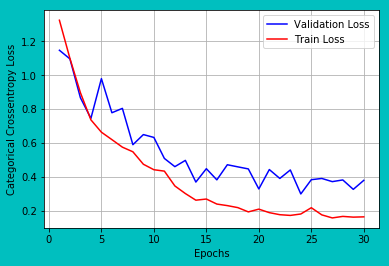

In [20]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
test_acc1= scores[1]*100
train_acc1=(max(hist1.history['acc']))* 100
print("Train Accuracy: %f%%"% (train_acc1))
                       
print("Test Accuracy: %f%%" % (test_acc1))

# error plot
x=list(range(1,epochs+1))
vy=hist1.history['val_loss'] #validation loss
ty=hist1.history['loss'] # train loss
plt_dynamic(x, vy, ty)


#### Observation:
 * From above plot,it can be diagnosied that model is performing overfitting.
 * The training error graph is reducing continuously and Validation graph is descreasing upto inflection point and later it's increasing.

1st
2nd
3rd
4th


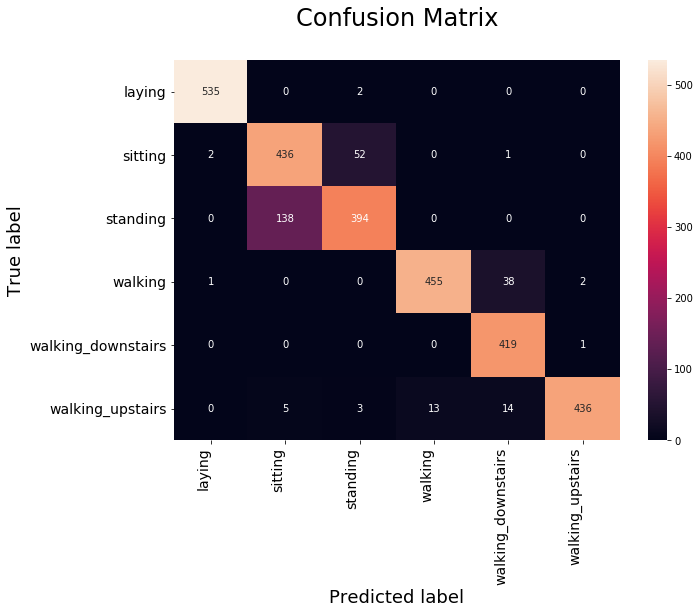

In [21]:
# Confusion_Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
print('1st')                     
                       
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), 
                                                         axis=1)])
print('2nd')  

# seaborn heatmaps
class_names = ['laying','sitting',
               'standing','walking',
               'walking_downstairs',
               'walking_upstairs']
con_mat=confusion_matrix(Y_true,Y_predictions)
print('3rd')
df_heatmap = pd.DataFrame(con_mat, 
                          index=class_names, 
                          columns=class_names )
print('4th')
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, 
                      annot=True, fmt="d")

#  heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                             rotation=0,
                             ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                             rotation=90, ha='right',
                             fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# 2) 32 LSTM + 1 layer LSTM + Adam optimizer

In [22]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(32, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Training the model
hist2=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 24s 3ms/step - loss: 1.3700 - acc: 0.4207 - val_loss: 1.3605 - val_acc: 0.3858
Epoch 2/30
7352/7352 [==============================] - 24s 3ms/step - loss: 1.2399 - acc: 0.4460 - val_loss: 1.3068 - val_acc: 0.4150
Epoch 3/30
7352/7352 [==============================] - 24s 3ms/step - loss: 1.1828 - 

Test Score: 0.274399
Train Accuracy: 93.103917%
Test Accuracy: 89.989820%


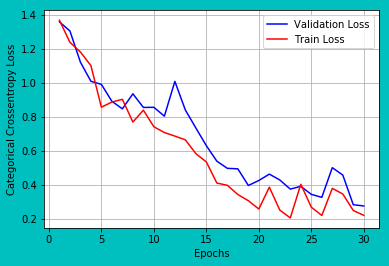

In [23]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
test_acc2= scores[1]*100
train_acc2=(max(hist2.history['acc']))* 100
print("Train Accuracy: %f%%"% (train_acc2))
                       
print("Test Accuracy: %f%%" % (test_acc2))
# error plot
x=list(range(1,epochs+1))
vy=hist2.history['val_loss'] #validation loss
ty=hist2.history['loss'] # train loss
plt_dynamic(x, vy, ty)

* Above model performs overfitting.

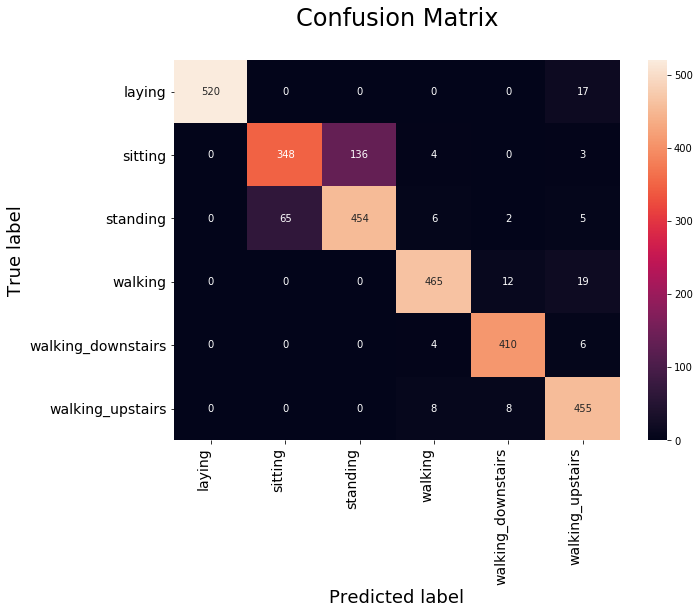

In [24]:

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])

# seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

#  heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                             rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                             rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# 3) 64 LSTM + 1 layer LSTM + rmsprop optimizer

In [25]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(64, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
# Training the model
hist3=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 31s 4ms/step - loss: 1.2827 - acc: 0.4340 - val_loss: 1.1831 - val_acc: 0.4574
Epoch 2/30
7352/7352 [==============================] - 30s 4ms/step - loss: 1.0405 - acc: 0.5345 - val_loss: 0.9734 - val_acc: 0.5667
Epoch 3/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.7448 

Test Score: 0.544287
Train Accuracy: 95.198585%
Test Accuracy: 90.193417%


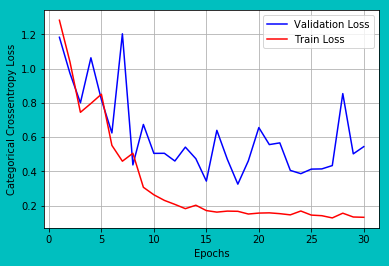

In [26]:

scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
test_acc3= scores[1]*100
train_acc3=(max(hist3.history['acc']))* 100
print("Train Accuracy: %f%%"% (train_acc3))
                       
print("Test Accuracy: %f%%" % (test_acc3))
# error plot
x=list(range(1,epochs+1))
vy=hist3.history['val_loss'] #validation loss
ty=hist3.history['loss'] # train loss
plt_dynamic(x, vy, ty)


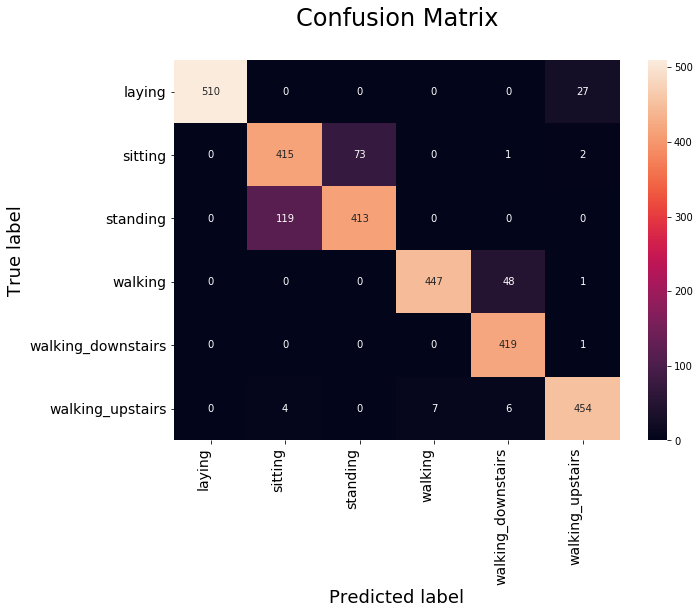

In [27]:


# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])

# seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

#  heatmap 
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                             rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                             rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# 4) 64 LSTM + 1 layer LSTM + adam optimizer

In [28]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(64, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Training the model
hist4=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 30s 4ms/step - loss: 1.3861 - acc: 0.3980 - val_loss: 1.3311 - val_acc: 0.3987
Epoch 2/30
7352/7352 [==============================] - 29s 4ms/step - loss: 1.2646 - acc: 0.4353 - val_loss: 1.3222 - val_acc: 0.4506
Epoch 3/30
7352/7352 [==============================] - 29s 4ms/step - loss: 1.3928 

Test Score: 0.382528
Train Accuracy: 92.315016%
Test Accuracy: 89.277231%


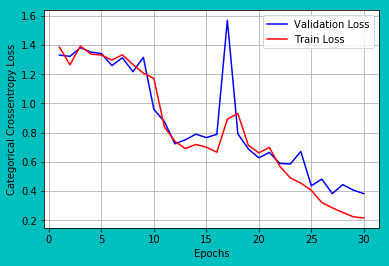

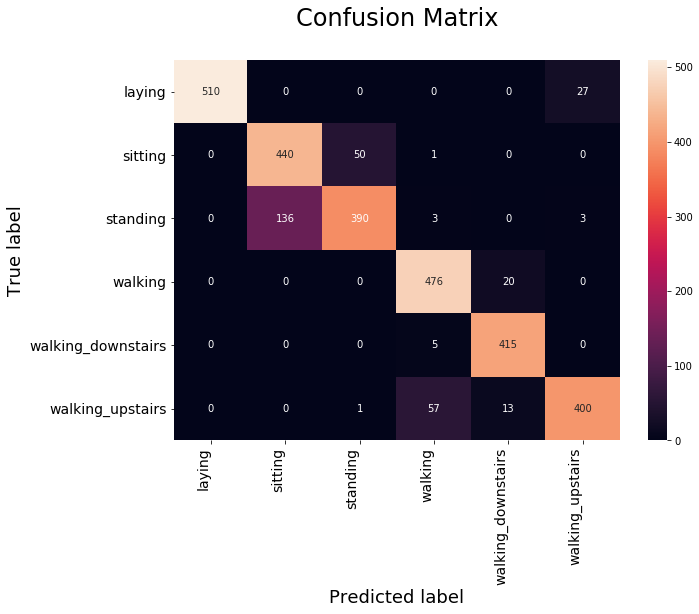

In [29]:


scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
test_acc4= scores[1]*100
train_acc4=(max(hist4.history['acc']))* 100
print("Train Accuracy: %f%%"% (train_acc4))
                       
print("Test Accuracy: %f%%" % (test_acc4))
# error plot
vy=hist4.history['val_loss'] #validation loss
ty=hist4.history['loss'] # train loss
plt_dynamic(x, vy, ty)

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])

# seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

#  heatmap 
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                             rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                             rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# 5) 32 LSTM + 2 layer LSTM + rmsprop optimizer

In [30]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(32,return_sequences=True,
               input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.65))
# second LSTM layer
model.add(LSTM(32))
model.add(Dropout(0.65))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
# Training the model
hist5=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 54s 7ms/step - loss: 1.3149 - acc:

Test Score: 0.579289
Train Accuracy: 94.545702%
Test Accuracy: 90.091619%


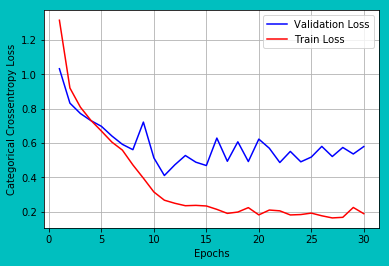

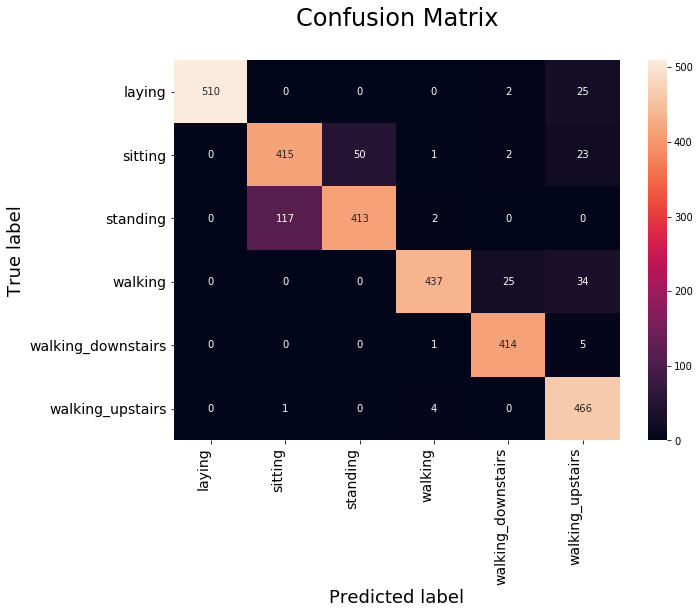

In [31]:


scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
test_acc5= scores[1]*100
train_acc5=(max(hist5.history['acc']))* 100
print("Train Accuracy: %f%%"% (train_acc5))
                       
print("Test Accuracy: %f%%" % (test_acc5))
# error plot
vy=hist5.history['val_loss'] #validation loss
ty=hist5.history['loss'] # train loss
plt_dynamic(x, vy, ty)

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])

# seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

#  heatmap 
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                             rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                             rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

 # 6) 32 LSTM + 2 layer LSTM + adam optimizer
 

In [32]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(32,return_sequences=True,
               input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.65))
# second LSTM layer
model.add(LSTM(32))
model.add(Dropout(0.65))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Training the model
hist6=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_8 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 56s 8ms/step - loss: 1.3817 - acc:

Test Score: 0.406773
Train Accuracy: 85.065288%
Test Accuracy: 86.630472%


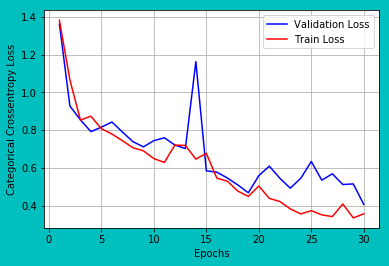

In [33]:


scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
test_acc6= scores[1]*100
train_acc6=(max(hist6.history['acc']))* 100
print("Train Accuracy: %f%%"% (train_acc6))
                       
print("Test Accuracy: %f%%" % (test_acc6))
# error plot
vy=hist6.history['val_loss'] #validation loss
ty=hist6.history['loss'] # train loss
plt_dynamic(x, vy, ty)

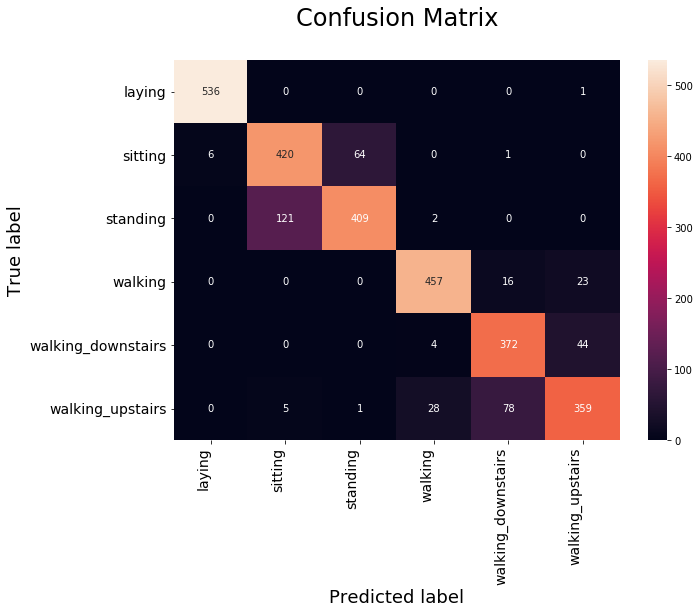

In [34]:


# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])

# seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

#  heatmap 
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                             rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                             rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

 # 7) 64 LSTM + 2 layer LSTM + adam optimizer+ 0.65 drop_out

In [35]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(64,return_sequences=True,
               input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.65))
# second LSTM layer
model.add(LSTM(64))
model.add(Dropout(0.65))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Training the model
hist7=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 75s 10ms/step - loss: 1.2460 - acc

Test Score: 0.450901
Train Accuracy: 95.307399%
Test Accuracy: 89.548694%


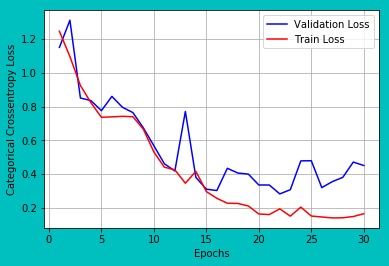

In [36]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
test_acc7= scores[1]*100
train_acc7=(max(hist7.history['acc']))* 100
print("Train Accuracy: %f%%"% (train_acc7))
                       
print("Test Accuracy: %f%%" % (test_acc7))
# error plot
vy=hist7.history['val_loss'] #validation loss
ty=hist7.history['loss'] # train loss
plt_dynamic(x, vy, ty)

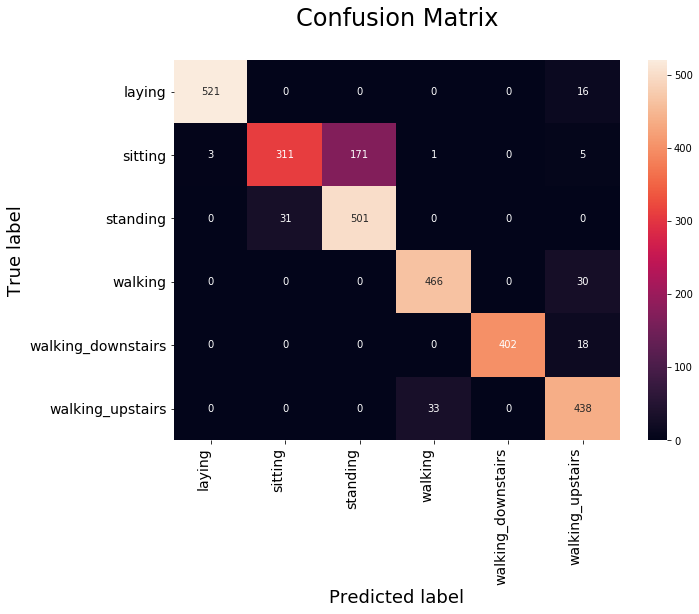

In [37]:



# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])

# seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

#  heatmap 
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                             rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                             rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

 # 8) 64 LSTM + 2 layer LSTM + rmsprop optimizer+ 0.65 drop_out

In [38]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(64,return_sequences=True,
               input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.65))
# second LSTM layer
model.add(LSTM(64))
model.add(Dropout(0.65))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# Training the model
hist8=model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 128, 64)           18944     
_________________________________________________________________
dropout_11 (Dropout)         (None, 128, 64)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 64)                33024     
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________
Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 76s 10ms/step - loss: 1.2849 - acc

Test Score: 0.366313
Train Accuracy: 95.144178%
Test Accuracy: 89.277231%


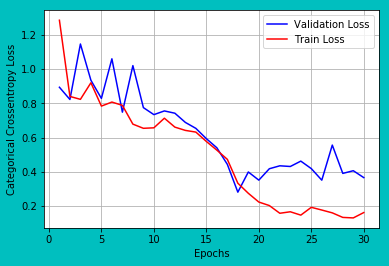

In [39]:
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
test_acc8= scores[1]*100
train_acc8=(max(hist8.history['acc']))* 100
print("Train Accuracy: %f%%"% (train_acc8))
                       
print("Test Accuracy: %f%%" % (test_acc8))
# error plot
vy=hist8.history['val_loss'] #validation loss
ty=hist8.history['loss'] # train loss
plt_dynamic(x, vy, ty)

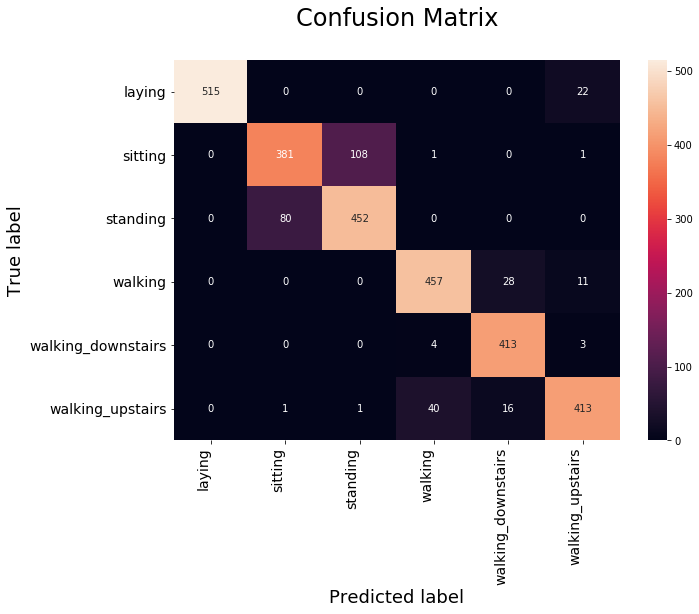

In [40]:


# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])

# seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

#  heatmap 
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(),
                             rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(),
                             rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Observation

In [41]:
from prettytable import PrettyTable
models=['32LSTM+1layerLSTM +rmsprop_optimizer',
        '32LSTM+1layerLSTM +adam_optimizer',
        '64LSTM+1layerLSTM +rmsprop_optimizer',
        '64LSTM+1layerLSTM +adam_optimizer',
        '32LSTM+2layerLSTM +rmsprop_optimizer+0.65drop_out',
        '32LSTM+2layerLSTM +adam_optimizer+0.65drop_out',
    '64LSTM+2layerLSTM+adam_optimizer+0.65drop_out',
    '64LSTM+2layerLSTM+rmsprop_optimizer+0.65drop_out']
training_accuracy=[train_acc1,train_acc2,train_acc3,
                  train_acc4,train_acc5,train_acc6,train_acc7,
                  train_acc8]
test_accuracy=[test_acc1,test_acc2,test_acc3,test_acc4,
              test_acc5,test_acc6,test_acc7,test_acc8]
INDEX = [1,2,3,4,5,6,7,8]
# Initializing prettytable
Model_Performance = PrettyTable()
# Adding columns
Model_Performance.add_column("INDEX.",INDEX)
Model_Performance.add_column("MODEL_NAME",models)
Model_Performance.add_column("TRAINING ACCURACY",training_accuracy)
Model_Performance.add_column("TESTING ACCURACY",test_accuracy)
#Model_Performance.add_column("TEST SCORE",test_score)

# Printing the Model_Performance
print(Model_Performance)

+--------+---------------------------------------------------+-------------------+-------------------+
| INDEX. |                     MODEL_NAME                    | TRAINING ACCURACY |  TESTING ACCURACY |
+--------+---------------------------------------------------+-------------------+-------------------+
|   1    |        32LSTM+1layerLSTM +rmsprop_optimizer       | 94.73612622415669 | 90.77027485578554 |
|   2    |         32LSTM+1layerLSTM +adam_optimizer         | 93.10391730141458 | 89.98982015609094 |
|   3    |        64LSTM+1layerLSTM +rmsprop_optimizer       | 95.19858541893362 | 90.19341703427214 |
|   4    |         64LSTM+1layerLSTM +adam_optimizer         | 92.31501632208922 | 89.27723108245674 |
|   5    | 32LSTM+2layerLSTM +rmsprop_optimizer+0.65drop_out | 94.54570184983679 | 90.09161859518154 |
|   6    |   32LSTM+2layerLSTM +adam_optimizer+0.65drop_out  | 85.06528835690969 | 86.63047166610112 |
|   7    |   64LSTM+2layerLSTM+adam_optimizer+0.65drop_out   | 95.3073993

# OBSERVATIONS:

* After increasing the hidden layers from 32 to 64 with 1 layer LSTM, model test accuracy has decreased.
* On increasing the number of LSTM layers, we found that model performing good on validation data, but not on test data. And hence is overfitting.
* RMS optimizer is prerforming better than adam optimiser.


# AIM - To increase accuracy above 94% 

# Model 9

In [0]:
# With One LSTM Layer Model 1  # 
n_hidden = 80

model = Sequential()

# 1 LSTM layer
model.add(LSTM(n_hidden, input_shape = (timesteps, input_dim)))     # 1 LSTM

model.add(Dropout(0.25))
model.add(Dense(n_classes, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 80)                28800     
_________________________________________________________________
dropout_4 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 486       
Total params: 29,286
Trainable params: 29,286
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size=64,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 31s 4ms/step - loss: 0.4190 - acc: 0.8390 - val_loss: 0.3644 - val_acc: 0.8571
Epoch 2/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.3535 - acc: 0.8616 - val_loss: 0.3331 - val_acc: 0.8613
Epoch 3/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.3183 - acc: 0.8736 - val_loss: 0.3162 - val_acc: 0.8704
Epoch 4/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.2887 - acc: 0.8776 - val_loss: 0.2728 - val_acc: 0.8806
Epoch 5/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.2342 - acc: 0.8948 - val_loss: 0.2279 - val_acc: 0.8955
Epoch 6/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.2182 - acc: 0.8994 - val_loss: 0.2412 - val_acc: 0.8933
Epoch 7/30
7352/7352 [==============================] - 30s 4ms/step - loss: 0.2087 - acc: 0.9015 - val_loss: 0.2105 - val_acc: 0.9009
Epoch 8

In [0]:
score = model.evaluate(X_test, Y_test)
print(score)

2947/2947 [==============================] - 8s 3ms/step
[0.09848940819087885, 0.9662934093908977]


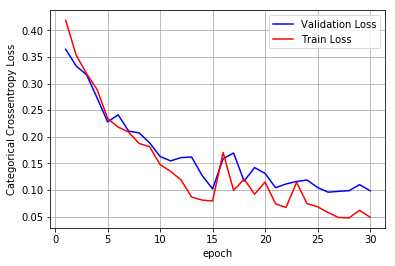

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

# Model 10

In [0]:
# With One LSTM Layer Model 1  # 
n_hidden = 80

model = Sequential()

# 1 LSTM layer
model.add(LSTM(n_hidden, input_shape = (timesteps, input_dim), return_sequences = True))     # 1 LSTM

model.add(Dropout(0.25))
model.add(LSTM(n_hidden)) 
model.add(Dense(n_classes, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])
print(model.summary())





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128, 80)           28800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 80)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 80)                51520     
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 486       
Total params: 80,806
Trainable params: 80,806
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
%%time
# Training the model
history = model.fit(X_train,
          Y_train,
          batch_size= 64,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.0341 - acc: 0.9861 - val_loss: 0.0949 - val_acc: 0.9742
Epoch 2/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.0371 - acc: 0.9852 - val_loss: 0.1142 - val_acc: 0.9724
Epoch 3/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.0352 - acc: 0.9856 - val_loss: 0.1288 - val_acc: 0.9688
Epoch 4/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.0390 - acc: 0.9845 - val_loss: 0.0962 - val_acc: 0.9751
Epoch 5/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.0366 - acc: 0.9847 - val_loss: 0.1185 - val_acc: 0.9722
Epoch 6/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.0370 - acc: 0.9849 - val_loss: 0.1057 - val_acc: 0.9723
Epoch 7/30
7352/7352 [==============================] - 58s 8ms/step - loss: 0.0331 - acc: 0.9867 - val_loss: 0.1143 - val_acc: 0.9738
Epoch 8

In [0]:
score = model.evaluate(X_test, Y_test)
print(score)

2947/2947 [==============================] - 17s 6ms/step
[0.1007159318419772, 0.9716095518248745]


In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 511        0  ...                   0                 0
SITTING                  0      351  ...                   0                 2
STANDING                 0       22  ...                   1                 0
WALKING                  0        0  ...                  43                 1
WALKING_DOWNSTAIRS       0        0  ...                 420                 0
WALKING_UPSTAIRS         0        4  ...                  14               440

[6 rows x 6 columns]


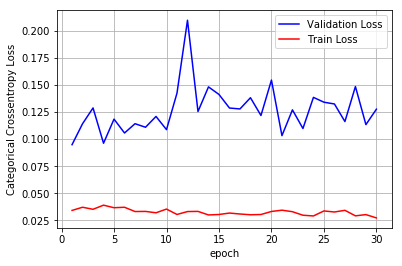

In [0]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')

# list of epoch numbers
x = list(range(1,epochs+1))

# print(history.history.keys())
# dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
# history = model_drop.fit(X_train, Y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, validation_data=(X_test, Y_test))

# we will get val_loss and val_acc only when you pass the paramter validation_data
# val_loss : validation loss
# val_acc : validation accuracy

# loss : training loss
# acc : train accuracy
# for each key in histrory.histrory we will have a list of length equal to number of epochs

vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

# Conclusion

In [2]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model","Hidden layer","activation","Optimizer", "Test accuracy in %"]

x.add_row(["MODEL-9 : Lstm + dropout(0.25)","80","sigmoid" ,"Adam", "96.62%"])
x.add_row(["MODEL-10 :Lstm + dropout(0.25)","80","sigmoid","rmsprop" ,"97.16%"])


print(x)

+--------------------------------+--------------+------------+-----------+--------------------+
|             Model              | Hidden layer | activation | Optimizer | Test accuracy in % |
+--------------------------------+--------------+------------+-----------+--------------------+
| MODEL-9 : Lstm + dropout(0.25) |      80      |  sigmoid   |    Adam   |       96.62%       |
| MODEL-10 :Lstm + dropout(0.25) |      80      |  sigmoid   |  rmsprop  |       97.16%       |
+--------------------------------+--------------+------------+-----------+--------------------+


* By increasing the hidden layers to 80 we got a very good result. 
* Lstm + dropout(0.25) model ,with 80 hidden layers with "sigmoid" activation function we got a test acccuracy of 97.16%.